# Cuaderno 10: Flujo de costo mínimo (mincost flow)

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

### Observación:
Empezaremos a partir de este cuaderno con problemas de optimización sobre grafos dirigidos y no dirigidos. Un grafo dirigido $D=(V,A)$ es un par ordenado que consiste de un conjunto finito de _vértices o nodos_ $V$ y un conjunto $A \subseteq V \times V$ de _arcos_.

**Ejemplo:**

$V = \{1, 2, 3, 4, 5 \}$

$A = \{(1,2),(1,3),(2,3),(2,4),(5,4),(5,3),(3,4)\}$

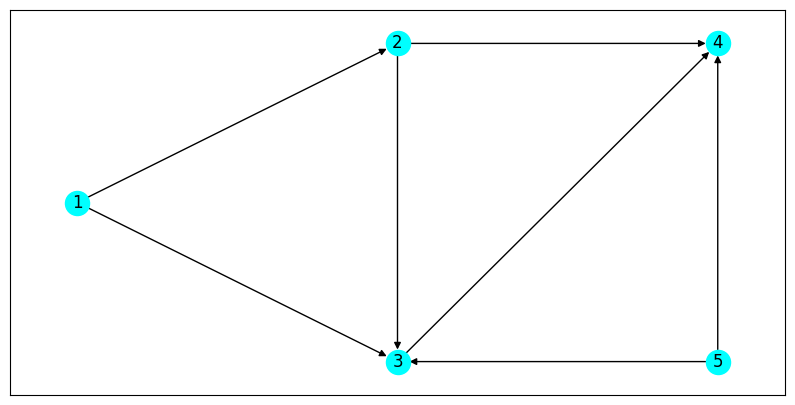

In [3]:
# Ejemplo de un grafo dirigido
V = [i+1 for i in range(5)]
A = [(1,2),(1,3),(2,3),(2,4),(5,4),(5,3),(3,4)]

# Se lo puede graficar con los módulos networkx y matplotlib
import networkx as nx
import matplotlib.pyplot as plt
D = nx.DiGraph()
D.add_nodes_from(V)
node_labels= {i : str(i) for i in V}
D.add_edges_from(A)
plt.figure(figsize=(10,5))
pos = {1 : (1,2), 2 : (2,3), 3 : (2,1), 4 : (3,3), 5 : (3,1)}
nx.draw_networkx(D, pos, labels= node_labels, node_color='cyan')

### Problema del flujo de costo mínimo

Dados: 
* un grafo dirigido $D=(V,A)$; 
* un vector de capacidades $u \in \ZZ^{A}_+$  asociadas a los arcos de $D$; 
* un vector $c \in \ZZ^{A}$ de costos de transporte unitarios asociados a los arcos de $D$; y, 
* un vector $b \in \ZZ^{V}$ de demandas asociadas a los nodos de $D$.

El *problema de flujo de costo mínimo (mincost flow, MCF)* consiste en encontrar un flujo $x \in \RR^{A}_{+}$  que satisfaga las siguientes condiciones:

* para cada nodo $i \in V$, el flujo neto en $i$ (definido como el flujo total sobre los arcos que entran a $i$ menos el flujo total sobre los arcos qe salen de $i$) debe ser igual a la demanda $b_i$ del nodo $i$;  
* el flujo sobre cada arco $(i,j) \in A$ debe ser menor o igual a su capacidad $u_{ij}$;
* el costo total del flujo debe ser mínimo. Este costo se calcula al multiplicar el flujo sobre cada arco $(i,j) \in A$ por su correspondiente costo unitario de transportación $c_{ij}$, y sumar estos valores sobre todos los arcos de la red.

Utilizando variables continuas no negativas $x_{ij}$ para representar el flujo sobre el arco $(i, j) \in A$, el problema de flujo de costo mínimo puede formularse como el siguiente programa lineal:

\begin{align*}
\min &\sum_{(i,j) \in A} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{(j, i) \in A} x_{ji} - \sum_{(i, j) \in A} x_{ij} = b_i, \quad \forall i \in V,\\
& 0 \leq x_{ij} \leq u_{ij}, \quad \forall (i, j) \in A.
\end{align*}


Vamos a implementar este modelo usando la interfaz Python de Gurobi.

Utilizaremos como ejemplo la instancia dada a continuación:

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Nodos del grafo
V = gp.tuplelist(['a', 'b', 'c', 'd', 'e', 'f'])

# Arcos, capacidades y costos unitarios
# (i,j) : (u_ij, c_ij)
A, u, c = gp.multidict({
  ('a', 'b'):   (10, 2),
  ('a', 'c'):   ( 5, 1),
  ('c', 'b'):   (20, 2),
  ('b', 'd'):   (10, 1),
  ('c', 'e'):   (40, 4),
  ('d', 'c'):   (20, 3),
  ('e', 'd'):   (20, 1),
  ('e', 'f'):   (15, 3),
  ('d', 'f'):   (10, 2)})

# Demandas asociadas a nodos 
b = gp.tupledict({
  'a':  -10,
  'b':   25,
  'c':  -30,
  'd':  -15,
  'e':   10,
  'f':   20})

El grafo asociado puede ser representado visualmente empleando las bibliotecas `networkx` y `matplotlib`:

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
D = nx.DiGraph()
D.add_nodes_from(V)
node_labels= {i : str(i) + '\n' + str(b[i]) for i in V}
D.add_edges_from(A)
edge_labels = {(i,j) : str(u[i,j]) + ',' + str(c[i,j]) for (i,j) in A}
plt.figure(figsize=(10,5))
pos = {'a' : (1,2), 'b' : (2,3), 'c' : (2,1), 'd' : (3,3), 'e' : (3,1), 'f':(4,2)}
nx.draw_networkx(D, pos, labels= node_labels, node_color='cyan', node_size=1000)
nx.draw_networkx_edge_labels(D, pos, edge_labels)
plt.show()

Creamos ahora el objeto modelo y las variables de flujo $x_{ij}$. Observar que las variables están indexadas por los conjuntos de arcos.

Si no se especifica el argumento `vtype` en la llamada a la función `addVars`, por defecto las variables creadas son continuas y no negativas.

Notar cómo el argumento `ub` de la función `addVars` puede usarse para especificar cotas superiores para cada variable. De esta manera, las restricciones de capacidad quedan incluidas ya en la definición de las variables. De manera similar, es posible utilizar el argumento `lb` para especificar cotas inferiores para las variables, aunque en este caso no es necesario, pues por defecto las variables tienen cotas inferiores iguales a cero.

In [ ]:
# Crear el objeto modelo
m = gp.Model('mincost-flow')

# Crear las variables
x = m.addVars(A, name="x", ub=u)

Definimos la función objetivo a minimizar:

In [ ]:
m.setObjective(x.prod(c, '*'), GRB.MINIMIZE)

Definimos las restricciones del modelo:

In [ ]:
# Restricciones de demanda en los nodos
m.addConstrs(
    (x.sum('*',i) - x.sum(i,'*')  == b[i] for i in V), "demanda")

Finalmente, resolvemos el modelo y mostramos la solución. Notar que los valores de las variables pueden recuperarse también empleando el método `getAttr`:

In [ ]:
# Calcular la solución óptima
m.optimize()

# Escribir la solución
if m.SolCount > 0:
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('Flujos óptimos:')
    for i,j in A:
        if vx[i,j] >= 0.01:
            print('{} -> {}: {}'.format(i, j, vx[i,j]))

## Visualizando grafos

Existen algunos módulos especializados en Python para trabajar con grafos. Entre ellos están:
* `NetworkX`, que contiene estructuras de datos para el trabajo con grafos e implementaciones de algoritmos para la exploración de grafos y la solución de problemas clásicos de optimización; más información [aquí.](https://networkx.github.io/documentation/stable/) 
* `matplotlib`, que contiene numerosas opciones para generar gráficos de aplicaciones matemáticas en Python; más información [aquí.](https://matplotlib.org/)
* `ipycytoscape`, que contiene funciones para la visualización interactiva de grafos; más información [aquí.](https://blog.jupyter.org/interactive-graph-visualization-in-jupyter-with-ipycytoscape-a8828a54ab63)

Para instalar estos módulos podemos usar el comando `pip` **desde una terminal** o ejecutar una vez la siguiente celda (será necesario reiniciar el kernel de Jupyter después de hacerlo):


In [ ]:
import sys
!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install ipycytoscape
!{sys.executable} -m pip install matplotlib

### NetworkX y matplotlib
Combinando los módulos `NetworkX` y `matplotlib` podemos visualizar la solución del ejemplo anterior:

In [ ]:
D = nx.DiGraph()
D.add_nodes_from(V)
node_labels= {i : str(i) + '\n' + str(b[i]) for i in V}
D.add_edges_from(A)
edge_labels = {(i,j) : str(int(vx[i,j])) + '/' + str(u[i,j]) for (i,j) in A}
edge_colors = ['#ff007f' if vx[i,j]>=0.1 else '#9dbaea' for (i,j) in list(D.edges())]
plt.figure(figsize=(10,5))
pos = {'a' : (1,2), 'b' : (2,3), 'c' : (2,1), 'd' : (3,3), 'e' : (3,1), 'f':(4,2)}
nx.draw_networkx(D, pos, labels= node_labels, node_color='cyan', node_size=1000, edge_color= edge_colors)
nx.draw_networkx_edge_labels(D, pos, edge_labels)
plt.show()

### NetworkX y ipycytoscape
Combinando los módulos `NetworkX` e `ipycytoscape` podemos crear visualizaciones del grafo que sean más interactivas. El siguiente código muestra el ejemplo anterior:

In [ ]:
import networkx as nx
import ipycytoscape
D = nx.DiGraph()
D.add_nodes_from(V)
for i in V:
    D.nodes[i]['demanda']= str(i) + '\n' + str(b[i])
D.add_edges_from(A)
for i,j in A:
    D.edges[i,j]['cap_costo'] = u[i,j], c[i,j]
grafo = ipycytoscape.CytoscapeWidget()
grafo.graph.add_graph_from_networkx(D, directed=True)
grafo.set_style([{'selector': 'node', 'style' : {'background-color': '#11479e', 'font-family': 'helvetica', 'font-size': '10px', 'color':'white', 'label': 'data(demanda)', 'text-wrap' : 'wrap', 'text-valign' : 'center'}}, 
                    {'selector': 'node:parent', 'css': {'background-opacity': 0.333}, 'style' : {'font-family': 'helvetica', 'font-size': '10px', 'label': 'data(demanda)'}}, 
                    {'selector': 'edge', 'style': {'width': 4, 'line-color': '#9dbaea', 'font-size': '10px', 'label': 'data(cap_costo)', 'text-valign' : 'top', 'text-margin-y' : '-10px'}}, 
                    {'selector': 'edge.directed', 'style': {'curve-style': 'bezier', 'target-arrow-shape': 'triangle', 'target-arrow-color': '#9dbaea'}}])
grafo

Y también podemos visualizar la solución

In [ ]:
D = nx.DiGraph()
D.add_nodes_from(V)
for i in V:
    D.nodes[i]['demanda']= str(i) + '\n' + str(b[i])
D.add_edges_from(A)
for i,j in A:
    D.edges[i,j]['flujo_cap'] = str(int(vx[i,j])) + '/' + str(u[i,j]) 
    D.edges[i,j]['color'] =  '#9dbaea' if vx[i,j]<=0.1 else '#ff007f'
grafo = ipycytoscape.CytoscapeWidget()
grafo.graph.add_graph_from_networkx(D, directed=True)
grafo.set_style([{'selector': 'node', 'style' : {'background-color': '#11479e', 'font-family': 'helvetica', 'font-size': '10px', 'color':'white', 'label': 'data(demanda)', 'text-wrap' : 'wrap', 'text-valign' : 'center'}}, 
                    {'selector': 'node:parent', 'css': {'background-opacity': 0.333}, 'style' : {'font-family': 'helvetica', 'font-size': '10px', 'label': 'data(demanda)'}}, 
                    {'selector': 'edge', 'style': {'width': 4, 'line-color': 'data(color)', 'font-size': '10px', 'label': 'data(flujo_cap)', 'text-valign' : 'top', 'text-margin-y' : '-10px'}}, 
                    {'selector': 'edge.directed', 'style': {'curve-style': 'bezier', 'target-arrow-shape': 'triangle', 'target-arrow-color': 'data(color)'}}])
grafo

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

In [ ]:
# Implementación de modelos de programación lineal entera
# Problema de flujo de costo mínimo (mincost flow)

# Luis M. Torres (EPN 2022)

import gurobipy as gp
from gurobipy import GRB

# Nodos del grafo
V = gp.tuplelist(['a', 'b', 'c', 'd', 'e', 'f'])

# Arcos, capacidades y costos unitarios
A, u, c = gp.multidict({
  ('a', 'b'):   (10, 2),
  ('a', 'c'):   ( 5, 1),
  ('c', 'b'):   (20, 2),
  ('b', 'd'):   (10, 1),
  ('c', 'e'):   (40, 4),
  ('d', 'c'):   (20, 3),
  ('e', 'd'):   (20, 1),
  ('e', 'f'):   (15, 3),
  ('d', 'f'):   (10, 2)})

# Demandas asociadas a nodos 
b = gp.tupledict({
  'a':  -10,
  'b':   25,
  'c':  -30,
  'd':  -15,
  'e':   10,
  'f':   20})

try:
    # Crear el objeto modelo
    m = gp.Model('mincost-flow')

    # Crear las variables
    x = m.addVars(A, name="x", ub=u)

    # Definir la función objetivo
    m.setObjective(x.prod(c, '*'), GRB.MINIMIZE)

    # Restricciones de demenda en los nodos
    m.addConstrs(
        (x.sum('*',j) - x.sum(j,'*')  == b[j] for j in V), "demanda")

    # Calcular la solución optima
    m.optimize()

    # Escribir la solución
    if m.SolCount > 0:
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('Flujos optimos:')
        for i,j in A:
            if vx[i,j] > 0:
                print('{} -> {}: {}'.format(i, j, vx[i,j]))

except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')